In [247]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
from math import ceil

In [248]:
# Read in the images and convert to rgb
mos1_bgr = cv2.imread('mos1.jpg')
mos1_bgr = cv2.resize(mos1_bgr, (1280,1024))
mos1 = cv2.cvtColor(mos1_bgr, cv2.COLOR_BGR2RGB)

mos2_bgr = cv2.imread('mos2.jpg')
mos2_bgr = cv2.resize(mos2_bgr, (1280,1024))
mos2 = cv2.cvtColor(mos2_bgr, cv2.COLOR_BGR2RGB)

mos3_bgr = cv2.imread('mos3.jpg')
mos3_bgr = cv2.resize(mos3_bgr, (1280,1024))
mos3 = cv2.cvtColor(mos3_bgr, cv2.COLOR_BGR2RGB)

mos4_bgr = cv2.imread('mos4.jpg')
mos4_bgr = cv2.resize(mos4_bgr, (1280,1024))
mos4 = cv2.cvtColor(mos4_bgr, cv2.COLOR_BGR2RGB)

mos5_bgr = cv2.imread('mos5.jpg')
mos5_bgr = cv2.resize(mos5_bgr, (1280,1024))
mos5 = cv2.cvtColor(mos5_bgr, cv2.COLOR_BGR2RGB)

mos = [mos1, mos2, mos3, mos4, mos5]
mos_bgr = [mos1_bgr, mos2_bgr, mos3_bgr, mos4_bgr, mos5_bgr]

In [249]:
# Define which method to use to compute features and keypoints
def get_descriptor(img, method=None):
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
    
    (keypoints, features) = descriptor.detectAndCompute(img, None)
    return keypoints, features

## SIFT

We will examine SIFT first as a descriptor.

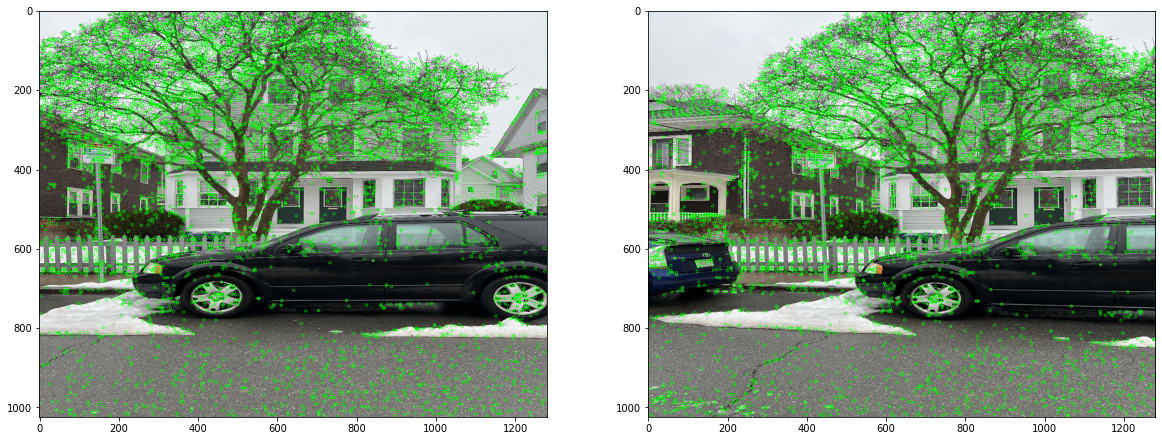

In [250]:
# Find keypoitns and features of each image using SIFT
kps_mos3, feat_mos3 = get_descriptor(mos3, method='sift')
kps_mos2, feat_mos2 = get_descriptor(mos2, method='sift')
kps_mos4, feat_mos4 = get_descriptor(mos4, method='sift')
kps_mos1, feat_mos1 = get_descriptor(mos1, method='sift')
kps_mos5, feat_mos5 = get_descriptor(mos5, method='sift')


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(cv2.drawKeypoints(mos3, kps_mos3, None, color=(0,255,0)))
ax2.imshow(cv2.drawKeypoints(mos2, kps_mos2, None, color=(0,255,0)))
plt.show()

There are lots of keypoints throughout the images. There is a lot of concentration in the tree but there are plenty of keypoints in the image from top to bottom. 

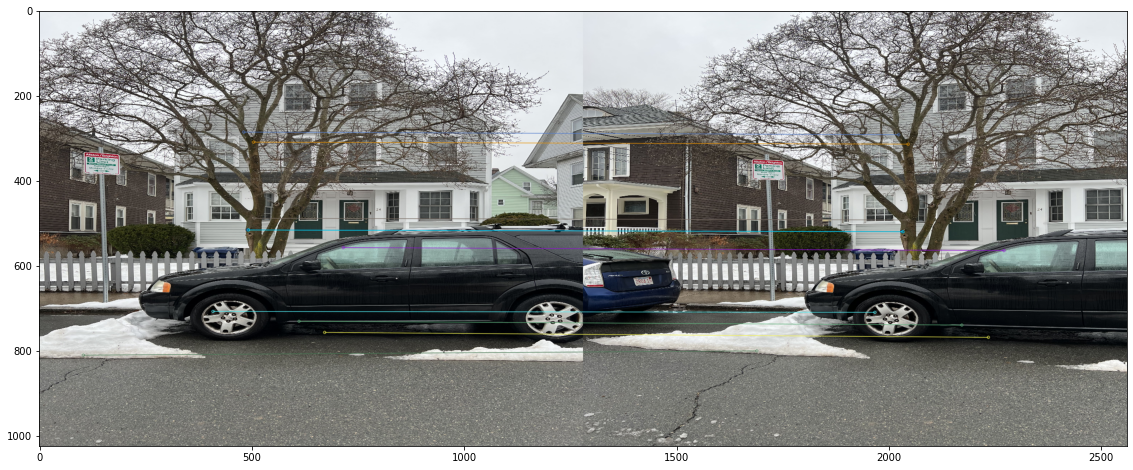

In [251]:
matches = []
#matches = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False).knnMatch(feat_mos3,feat_mos2, k=2)

# Initialize brute force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Match features of image 3 and image 2
matches_23 = bf.match(feat_mos3, feat_mos2)

# Sort the matches in order of distance, smallest first
raw_matches_23 = sorted(matches_23, key = lambda x:x.distance)

# good = []
# for m,n in ptsches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])

img3 = cv2.drawMatches(mos3,kps_mos3,mos2,kps_mos2,raw_matches_23[:10], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#img3 = cv2.drawMatchesKnn(mos3,kps_mos3,mos2,kps_mos2,good[:10], None,
                            #   matchColor=(0, 255, 0), matchesMask=None,
                            #   singlePointColor=(255, 0, 0), flags=0)
plt.figure(figsize=(20,8))
plt.imshow(img3)
plt.show()

The matches are extremely linear here looking at the 10 best matches. These matches are pretty spread out from closer to the bottom of the image to the top of the image. 

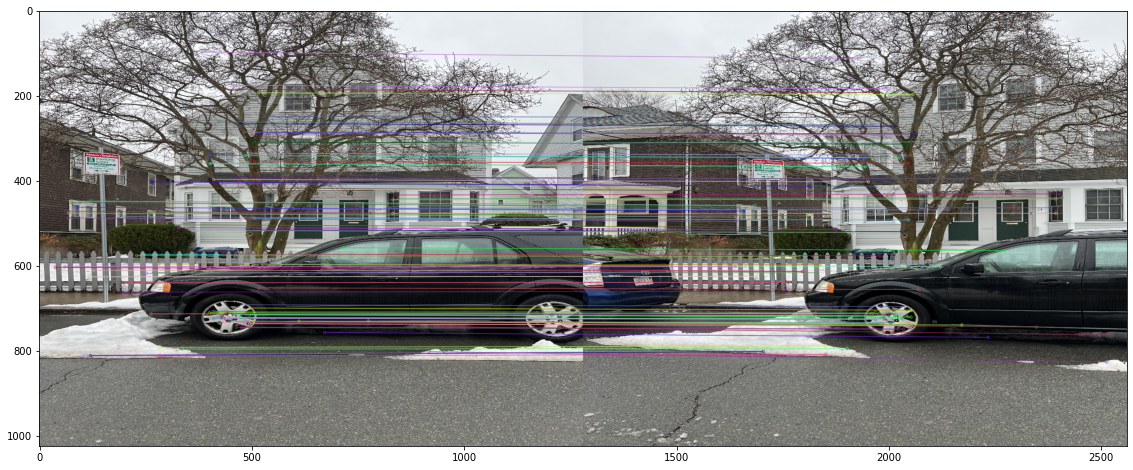

In [252]:
img3 = cv2.drawMatches(mos3,kps_mos3,mos2,kps_mos2,raw_matches_23[:100], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# img3 = cv2.drawMatchesKnn(mos3,kps_mos3,mos2,kps_mos2,good[:100], None,
#                               matchColor=(0, 255, 0), matchesMask=None,
#                               singlePointColor=(255, 0, 0), flags=0)
plt.figure(figsize=(20,8))
plt.imshow(img3)
plt.show()

Increasing to 100 matches still shows the same linearity across points and even these matches appearing very well spread out across the image.

In [253]:
# Set up A matrix to solve with SVD
def create_a_svd(img1points, img2points): # dest, source
    A = np.zeros((len(img1points)*2,9),dtype=int)
    for i in range(len(img1points)):
        A[2*i] = np.array([round(-img2points[i][0]), round(-img2points[i][1]), -1, 0, 0, 0, round(img2points[i][0])*round(img1points[i][0]), round(img2points[i][1])*round(img1points[i][0]), round(img1points[i][0])])
        A[2*i + 1] = np.array([0, 0, 0, round(-img2points[i][0]), round(-img2points[i][1]), -1, round(img2points[i][0])*round(img1points[i][1]), round(img2points[i][1])*round(img1points[i][1]), round(img1points[i][1])])
    return A

In [254]:
# Find homography using SVD
def homography_svd(dest_pts, src_pts):
    A = create_a_svd(dest_pts, src_pts)
    u, s, vh = np.linalg.svd(A)
    L = vh[-1,:] / vh[-1,-1]
    H = L.reshape(3, 3)

    return H

We will use 10 matches to create the A matrix and find the homography matrix

In [255]:
# Take first 10 keypoints from the matches with the shortest distance
mos3_pts_list = np.array(list([kps_mos3[pts.queryIdx].pt for pts in raw_matches_23[:10]])).astype('int')
mos2_pts_list = np.array(list([kps_mos2[pts.trainIdx].pt for pts in raw_matches_23[:10]])).astype('int')

mos3_pts = [kps_mos3[pts.queryIdx].pt for pts in raw_matches_23[:10]]
mos2_pts = [kps_mos2[pts.trainIdx].pt for pts in raw_matches_23[:10]]

h, status = cv2.findHomography(mos3_pts_list, mos2_pts_list)
print(h)

# Find homography and compare with opencv function
H23 = homography_svd(mos3_pts, mos2_pts)
print(H23)

[[ 7.67695083e-01  2.33265026e-02  2.96725724e+02]
 [-9.76131468e-02  8.97523982e-01  5.65382220e+01]
 [-1.72409968e-04 -1.71707922e-05  1.00000000e+00]]
[[ 1.39977179e+00 -1.31396956e-02 -4.40252347e+02]
 [ 1.62988725e-01  1.27820994e+00 -1.45510436e+02]
 [ 2.82294717e-04  5.98121887e-05  1.00000000e+00]]


In [256]:
# I took this from Jordan Gittleman and added the y axis to the calculation
def imgWarp(src,dest,H): # src image, dest image, Homography

    h1,w1 = src.shape[:2]
    h2,w2 = dest.shape[:2]
    pts = np.float32([[0,0], [0, h1],[w1, h1], [w1, 0]]) #create an array of just the corners in order top left, top right, bottom left, bottom right

    transPts=[]
    for pt in pts:
        transPts.append(np.matmul(H,np.array([pt[0],pt[1],1]))) # matmul the corners by the homography

    # Find minimum and maximum values for x and y of corners. This section was inspired by Xavier Hubbard
    x_min = min(pt[0]/pt[2] for pt in transPts)
    x_max = max(pt[0]/pt[2] for pt in transPts)
    y_min = min(pt[1]/pt[2] for pt in transPts)
    y_max = max(pt[1]/pt[2] for pt in transPts)

    if x_min < 0:
        x_shift = abs(x_min)
    elif x_min > 0:
        x_shift = 0

    if y_min <0:
        y_shift = abs(y_min)
    elif y_min > 0:
        y_shift = 0

    dim = (int(x_max+x_shift+w2),int(y_max+y_shift))

    transH = np.array([[1,0,np.ceil(x_shift)],[0,1,np.ceil(y_shift)],[0,0,1]]) # translation homography

    #now lets combine it with our original H!

    H_total=np.matmul(transH,H)

    # Warp image and keypoints
    out_img = cv2.warpPerspective(src,H_total,dim)
    out_dest_img = cv2.warpPerspective(dest,transH,dim)
    out_mask=np.any(out_img,2)
    out_mask=np.repeat(out_mask[:,:,np.newaxis], 3, axis=2)
    out_dest_mask=np.any(out_dest_img,2)
    out_dest_mask=np.repeat(out_dest_mask[:,:,np.newaxis], 3, axis=2)
    mask_result=np.bitwise_and(out_mask,out_dest_mask).astype("uint8")
    
    # Blend the images
    result = cv2.addWeighted(out_img, 0.5, out_dest_img, 0.5, 0)

    mask_result=(cv2.cvtColor(mask_result, cv2.COLOR_BGR2GRAY))

    output=cv2.bitwise_and(result,result,mask=mask_result)
    result=cv2.subtract(result,output)
    result=cv2.add(result,result)
    output2 = cv2.add(output, result)

    # cut out black space to the right of the image    
    h,w = output2.shape[:2]
    bounds=np.any(output2,2)
    edge=0
    for x in range(w-1,0,-1):
        if bounds[int(h/2), x] != 0:
            edge = x
            break
    output_im=output2[:,:edge,:]
    
    return (output_im, H_total, transH)

We will now start stitching the images starting with image 3 and image 2.

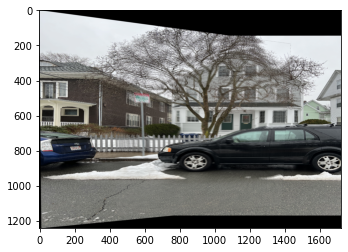

In [257]:
output, H2_3, trans_h23 = imgWarp(mos2,mos3, H23) # good

plt.figure()
plt.imshow(output)
plt.show()

Then image 4 with the previous output.

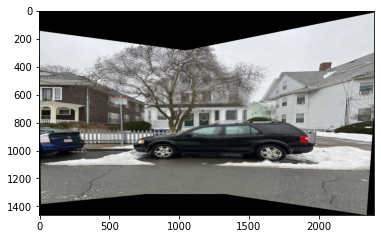

In [258]:
matches_43 = bf.match(feat_mos3, feat_mos4)

# Sort the matches in order of distance, smallest first
raw_matches_43 = sorted(matches_43, key = lambda x:x.distance)

mos34_pts = [kps_mos3[pts.queryIdx].pt for pts in raw_matches_43[:10]]
mos43_pts = [kps_mos4[pts.trainIdx].pt for pts in raw_matches_43[:10]]

H43 = homography_svd(mos34_pts, mos43_pts)

output1, H234, trans_h234 = imgWarp(mos4, output, np.matmul(trans_h23, H43)) # good

plt.figure()
plt.imshow(output1)
plt.show()

Now image 1 with the previous output.

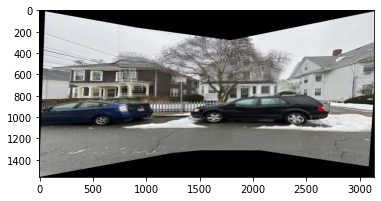

In [259]:
matches_21 = bf.match(feat_mos2, feat_mos1)

# Sort the matches in order of distance, smallest first
raw_matches_21 = sorted(matches_21, key = lambda x:x.distance)

mos21_pts = [kps_mos2[pts.queryIdx].pt for pts in raw_matches_21[:10]]
mos12_pts = [kps_mos1[pts.trainIdx].pt for pts in raw_matches_21[:10]]

H12 = homography_svd(mos21_pts, mos12_pts)

g = np.matmul(H2_3, H12)

output2, H1234, trans_h1234 = imgWarp(mos1, output1, np.matmul(trans_h234, g)) # good

plt.figure()
plt.imshow(output2)
plt.show()

Finally image 5 to complete the mosaic.

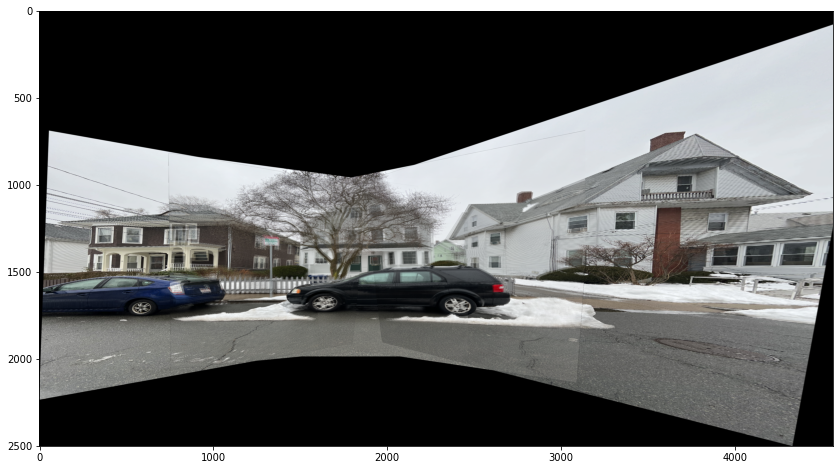

In [260]:
matches_45 = bf.match(feat_mos4, feat_mos5)

# Sort the matches in order of distance, smallest first
raw_matches_45 = sorted(matches_45, key = lambda x:x.distance)

mos45_pts = [kps_mos4[pts.queryIdx].pt for pts in raw_matches_45[:10]]
mos54_pts = [kps_mos5[pts.trainIdx].pt for pts in raw_matches_45[:10]]

H54 = homography_svd(mos45_pts, mos54_pts)

output3, H12345, trans_h12345 = imgWarp(mos5, output2, np.matmul(trans_h1234, np.matmul(H234, H54)))

plt.figure(figsize=(20,8))
plt.imshow(output3)
plt.show()

### RANSAC

We will now compute the same mosaic using openCVs function with RANSAC to find the homography.

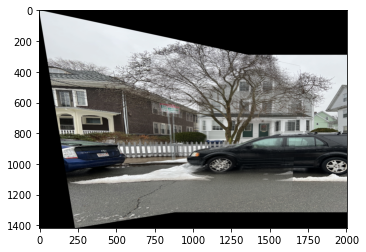

In [261]:
mos3_pts_list = np.array(list([kps_mos3[pts.queryIdx].pt for pts in raw_matches_23[:10]])).astype('int')
mos2_pts_list = np.array(list([kps_mos2[pts.trainIdx].pt for pts in raw_matches_23[:10]])).astype('int')

# Compute the homography with reprojection error 2.
H23 = cv2.findHomography(mos2_pts_list, mos3_pts_list, cv2.RANSAC, 2.0)

output, H2_3, trans_h23 = imgWarp(mos2,mos3, H23[0]) # good

plt.figure()
plt.imshow(output)
plt.show()

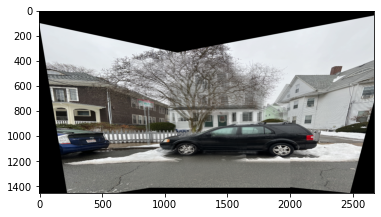

In [262]:
mos34_pts_list = np.array(list([kps_mos3[pts.queryIdx].pt for pts in raw_matches_43[:10]])).astype('int')
mos43_pts_list = np.array(list([kps_mos4[pts.trainIdx].pt for pts in raw_matches_43[:10]])).astype('int')

# Compute the homography with reprojection error 1
H43 = cv2.findHomography(mos43_pts_list, mos34_pts_list, cv2.RANSAC, 1.0)

output1, H234, trans_h234 = imgWarp(mos4, output, np.matmul(trans_h23, H43[0])) # good

plt.figure()
plt.imshow(output1)
plt.show()

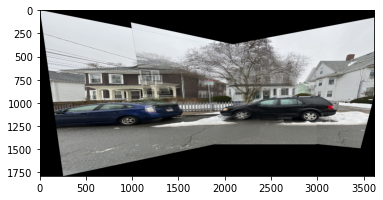

In [263]:
mos21_pts_list = np.array(list([kps_mos2[pts.queryIdx].pt for pts in raw_matches_21[:10]])).astype('int')
mos12_pts_list = np.array(list([kps_mos1[pts.trainIdx].pt for pts in raw_matches_21[:10]])).astype('int')

# Compute the homography with reprojection error 3
H12 = cv2.findHomography(mos12_pts_list, mos21_pts_list, cv2.RANSAC, 3.0)

output2, H1234, trans_h1234 = imgWarp(mos1, output1, np.matmul(trans_h234, np.matmul(H2_3, H12[0]))) # good

plt.figure()
plt.imshow(output2)
plt.show()

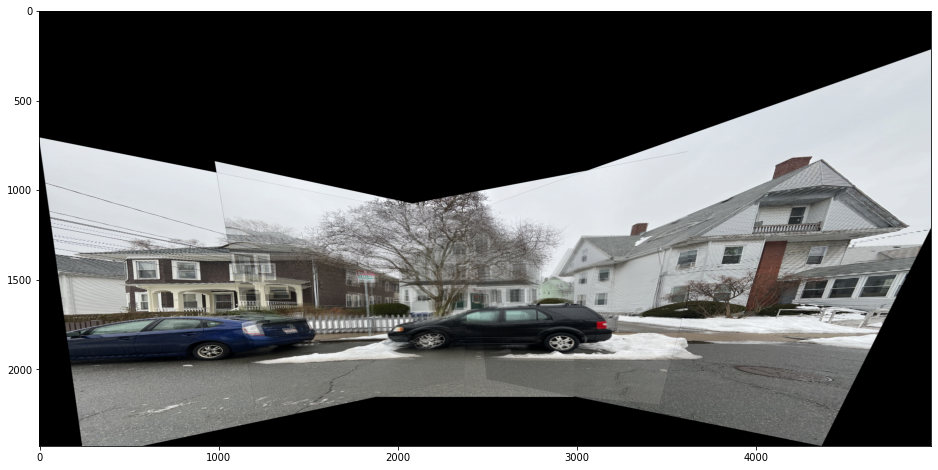

In [264]:
mos45_pts_list = np.array(list([kps_mos4[pts.queryIdx].pt for pts in raw_matches_45[:10]])).astype('int')
mos54_pts_list = np.array(list([kps_mos5[pts.trainIdx].pt for pts in raw_matches_45[:10]])).astype('int')

H54 = cv2.findHomography(mos54_pts_list, mos45_pts_list, cv2.RANSAC, 1.0)

output3, H12345, trans_h12345 = imgWarp(mos5, output2, np.matmul(trans_h1234, np.matmul(H234, H54[0])))

plt.figure(figsize=(20,8))
plt.imshow(output3)
plt.show()

With RANSAC, the output looks similar to without RANSAC but there is more blurring occurring between the 1st neighbors of the center image (image 3). I played with the reprojection errors to try and minimize the blurring but this was the best I could get.

## ORB

Now we will examine ORB

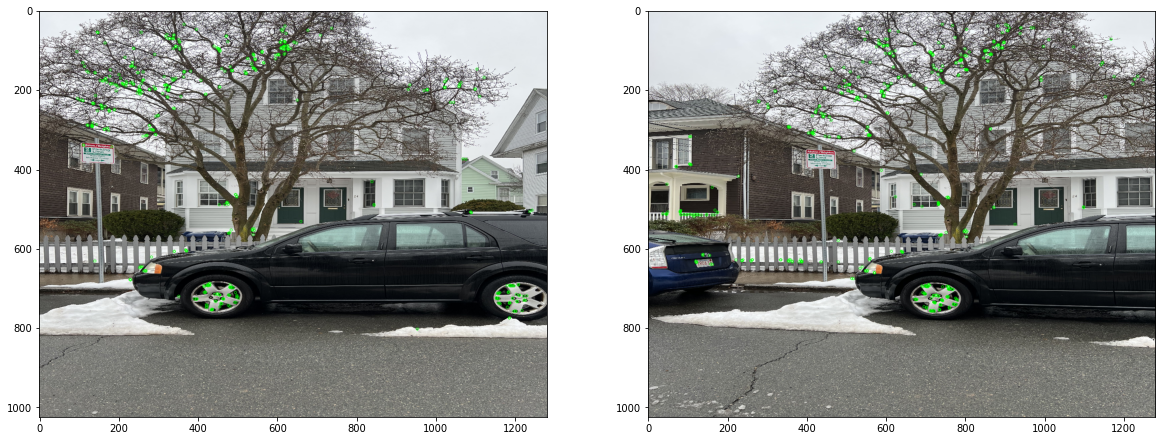

In [265]:
kps_mos3, feat_mos3 = get_descriptor(mos3, method='orb')
kps_mos2, feat_mos2 = get_descriptor(mos2, method='orb')
kps_mos4, feat_mos4 = get_descriptor(mos4, method='orb')
kps_mos1, feat_mos1 = get_descriptor(mos1, method='orb')
kps_mos5, feat_mos5 = get_descriptor(mos5, method='orb')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(cv2.drawKeypoints(mos3, kps_mos3, None, color=(0,255,0)))
ax2.imshow(cv2.drawKeypoints(mos2, kps_mos2, None, color=(0,255,0)))
plt.show()


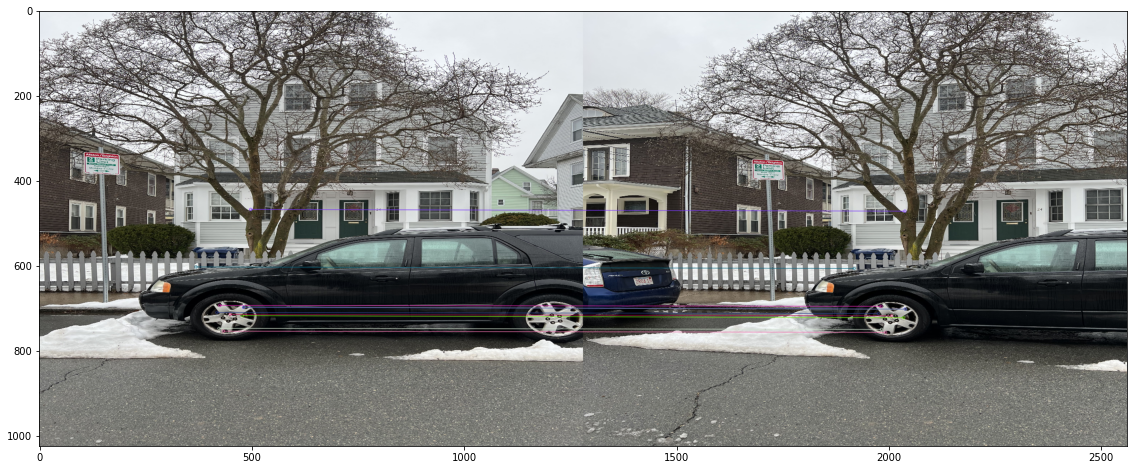

In [266]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_23 = bf.match(feat_mos3, feat_mos2)

# Sort the matches in order of distance, smallest first
raw_matches_23 = sorted(matches_23, key = lambda x:x.distance)

img3 = cv2.drawMatches(mos3,kps_mos3,mos2,kps_mos2,raw_matches_23[:10], None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,8))
plt.imshow(img3)
plt.show()

These matches are much lower on the image compared to SIFT. Much of these matches are concentrated on the lower end of the car.

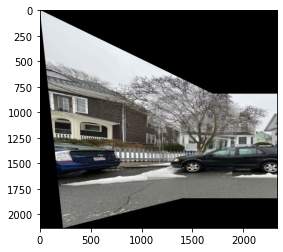

In [267]:
mos3_pts = [kps_mos3[pts.queryIdx].pt for pts in raw_matches_23[:10]]
mos2_pts = [kps_mos2[pts.trainIdx].pt for pts in raw_matches_23[:10]]

H23 = homography_svd(mos3_pts, mos2_pts)

output, H2_3, trans_h23 = imgWarp(mos2,mos3, H23) # good

plt.figure()
plt.imshow(output)
plt.show()

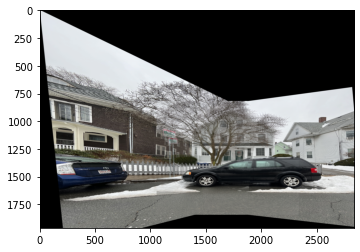

In [268]:
matches_43 = bf.match(feat_mos3, feat_mos4)

# Sort the matches in order of distance, smallest first
raw_matches_43 = sorted(matches_43, key = lambda x:x.distance)

mos34_pts = [kps_mos3[pts.queryIdx].pt for pts in raw_matches_43[:10]]
mos43_pts = [kps_mos4[pts.trainIdx].pt for pts in raw_matches_43[:10]]

H43 = homography_svd(mos34_pts, mos43_pts)

output1, H234, trans_h234 = imgWarp(mos4, output, np.matmul(trans_h23, H43)) # good

plt.figure()
plt.imshow(output1)
plt.show()

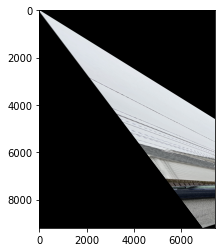

In [269]:
matches_21 = bf.match(feat_mos2, feat_mos1)

# Sort the matches in order of distance, smallest first
raw_matches_21 = sorted(matches_21, key = lambda x:x.distance)

mos21_pts = [kps_mos2[pts.queryIdx].pt for pts in raw_matches_21[:10]]
mos12_pts = [kps_mos1[pts.trainIdx].pt for pts in raw_matches_21[:10]]

H12 = homography_svd(mos21_pts, mos12_pts)

g = np.matmul(H2_3, H12)

output2, H1234, trans_h1234 = imgWarp(mos1, output1, np.matmul(trans_h234, g)) # good

plt.figure()
plt.imshow(output2)
plt.show()

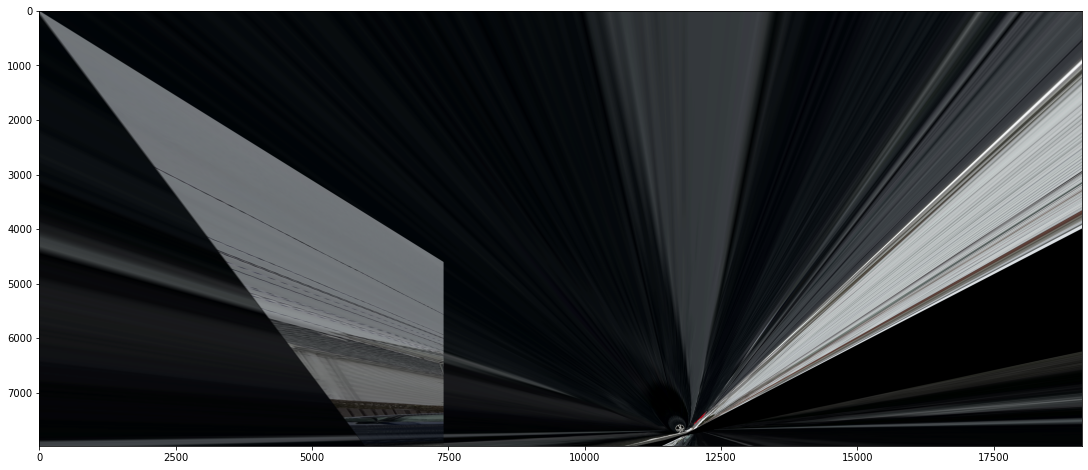

In [270]:
matches_45 = bf.match(feat_mos4, feat_mos5)

# Sort the matches in order of distance, smallest first
raw_matches_45 = sorted(matches_45, key = lambda x:x.distance)

mos45_pts = [kps_mos4[pts.queryIdx].pt for pts in raw_matches_45[:10]]
mos54_pts = [kps_mos5[pts.trainIdx].pt for pts in raw_matches_45[:10]]

H54 = homography_svd(mos45_pts, mos54_pts)

output3, H12345, trans_h12345 = imgWarp(mos5, output2, np.matmul(trans_h1234, np.matmul(H234, H54)))

plt.figure(figsize=(20,8))
plt.imshow(output3)
plt.show()

# Discussion

SIFT did a much better job than ORB in finding points. This obviously showed in creating the mosaic because there were not a lot of matches spread out through the image to create the homography and stitch together the images for ORB. SIFT showed a much better ability to find points of interest throughout the images. Furthermore, RANSAC showed similar results to SIFT without RANSAC while also playing with the numbers for the reprojection error. Overall, it seemed that SIFT did much better on this dataset which is odd considering ORB should still perform in a well-lit environment. Perhaps using a knn matcher may help but I think just looking at the number of points is too little.